In [124]:
import json
import numpy as np
import random
import pickle
import re
import colorama
import matplotlib.pyplot as plt
from colorama import Fore, Style
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [125]:

colorama.init()

# === 1. Cargar y Preprocesar Datos === #
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Záéíóúüñ¿?¡!., ]", "", text)  # Solo letras y puntuación
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Cargar datos del archivo JSON
with open('chatbot_data.json') as file:
    data = json.load(file)

# Preprocesamiento de datos
training_sentences = []
training_labels = []
labels = []
responses = []

# Procesar datos
for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(clean_text(pattern))  # Preprocesar texto
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

num_classes = len(labels)


In [126]:
# Codificación de etiquetas
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

# Tokenización y padding
vocab_size = 2000  # Aumentar tamaño del vocabulario
embedding_dim = 50  # Aumentar dimensión de embeddings
max_len = 25
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)


In [127]:


# Construcción del modelo
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())

# Capas densas con BatchNormalization y Dropout
model.add(Dense(254, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Capa de salida
model.add(Dense(num_classes, activation='softmax'))

# Compilación del modelo con tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

# Callbacks para Early Stopping y Reducción de LR
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# === 3. Entrenamiento del Modelo === #
history = model.fit(
    padded_sequences,
    np.array(training_labels),
    validation_split=0.2,  # Conjunto de validación al 20%
    batch_size=32,  # Tamaño de lote ajustado
    epochs=100,  # Número máximo de épocas
    callbacks=[early_stop, reduce_lr]
)

c:\Users\Tarda\anaconda3\envs\Canemcat\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_22     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.0312 - loss: 7.17 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0312 - loss: 7.066 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0347 - loss: 7.044 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0339 - loss: 7.034 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0343 - loss: 7.028 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.0346 - loss: 7.0242 - val_accuracy: 0.0000e+00 - val_loss: 5.9934 - learning_rate: 5.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0625 - loss: 6.701 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0484 - loss: 6.704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0464 - loss: 6.7059 - val_accuracy: 0.0000e+00 - val_loss: 5.9390 - learning_rate: 5.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0938 - loss: 6.875 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0611 - loss: 6.799 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0606 - loss: 6.780

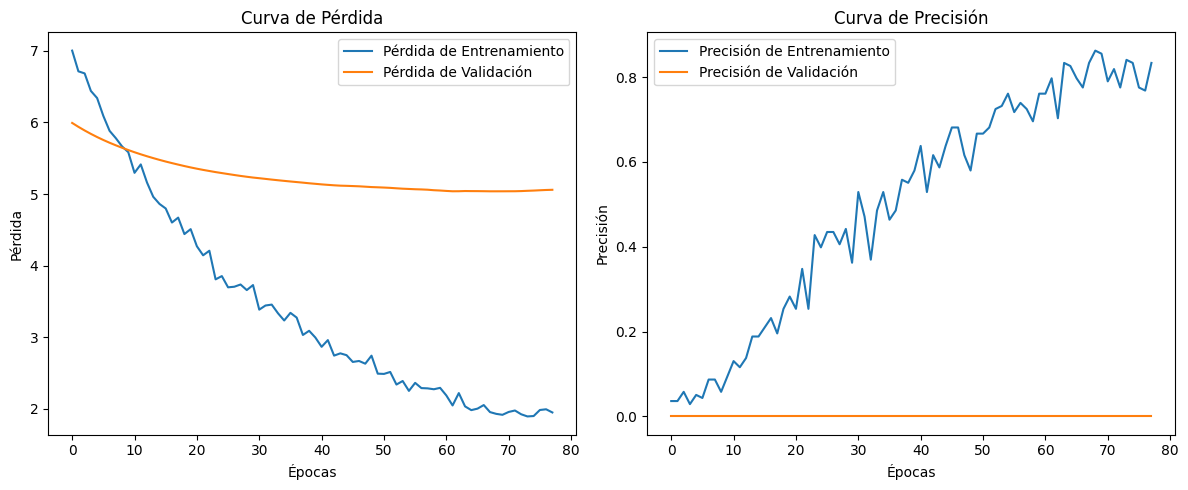

In [128]:

# Graficar métricas de entrenamiento
plt.figure(figsize=(12, 5))
# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva de Precisión')

plt.tight_layout()
plt.show()


In [129]:
# === 5. Guardar Modelo y Recursos === #
model.save("chat_model_optimized.h5")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)


In [130]:
# === 6. Chatbot Interactivo === #
def chat():
    from tensorflow import keras
    model = keras.models.load_model('chat_model_optimized.h5')

    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    max_len = 25
    print(Fore.YELLOW + "¡Empieza a hablar con el bot! (escribe 'quit' para salir)" + Style.RESET_ALL)
    while True:
        print(Fore.LIGHTBLUE_EX + "Usuario: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        # Preprocesar entrada del usuario
        inp_cleaned = clean_text(inp)
        result = model.predict(keras.preprocessing.sequence.pad_sequences(
            tokenizer.texts_to_sequences([inp_cleaned]),
            truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for intent in data['intents']:
            if intent['tag'] == tag[0]:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL, random.choice(intent['responses']))
                break

# Iniciar Chatbot
chat()


¡Empieza a hablar con el bot! (escribe 'quit' para salir)
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
ChatBot: ¡Buenos días! ¿Cómo puedo asistirte hoy?
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
ChatBot: Si estás interesado en adoptar, te recomendamos ponerte en contacto con las protectoras locales. ¿Te gustaría saber más sobre alguna protectora en particular?
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
ChatBot: ¡Buenos días! ¿Cómo puedo asistirte hoy?
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
ChatBot: Puedes registrarte como trabajador desde la sección 'Registro para trabajadores'. Solo necesitarás el correo de tu protectora.
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
ChatBot: Estos son los animales que has guardado en tu wishlist. ¿Te gustaría añadir más?
1/1ario:  ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste ━━━━━━━━━━━━━━━━━━━